In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pygad
import wandb
import tensorflow.keras.backend as K
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

tf.random.set_seed(0)
np.random.seed(0)

import matplotlib.pyplot as plt
import scipy.io as sio
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4656249127970221484
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2943156224
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9540750317575988202
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


2023-09-04 09:35:40.364182: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-04 09:35:40.364378: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-04 09:35:40.364500: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Generating and Visualizing the Dataset

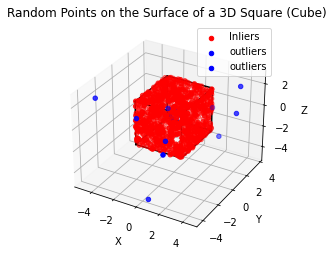

In [2]:
np.random.seed(0)

# Define the bounds of the 3D square (assuming a cube centered at the origin)
side_length = 4.0  # Adjust this as needed
x_min, x_max = -side_length / 2, side_length / 2
y_min, y_max = -side_length / 2, side_length / 2
z_min, z_max = -side_length / 2, side_length / 2

# Number of random points to generate
num_points = 1000  # Adjust this as needed

# Generate random points on the surface of the 3D square (cube)
random_points = []

for _ in range(num_points):
    axis = np.random.choice([0, 1, 2])  # Randomly select an axis (0 for x, 1 for y, 2 for z)
    sign = np.random.choice([-1, 1])   # Randomly select a sign (+1 or -1)

    if axis == 0:
        x = sign * side_length / 2
        y = np.random.uniform(y_min, y_max)
        z = np.random.uniform(z_min, z_max)
    elif axis == 1:
        x = np.random.uniform(x_min, x_max)
        y = sign * side_length / 2
        z = np.random.uniform(z_min, z_max)
    else:
        x = np.random.uniform(x_min, x_max)
        y = np.random.uniform(y_min, y_max)
        z = sign * side_length / 2

    random_points.append([x, y, z])

# Convert the list of random points to a NumPy array for easier manipulation
random_points = np.array(random_points)

# Plot the cube and random points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the cube's faces
vertices = [
    [x_min, y_min, z_min],
    [x_max, y_min, z_min],
    [x_max, y_max, z_min],
    [x_min, y_max, z_min],
    [x_min, y_min, z_max],
    [x_max, y_min, z_max],
    [x_max, y_max, z_max],
    [x_min, y_max, z_max]
]

# Define the edges of the cube
cube_edges = [
    [vertices[0], vertices[1], vertices[2], vertices[3], vertices[0]],
    [vertices[4], vertices[5], vertices[6], vertices[7], vertices[4]],
    [vertices[0], vertices[4]],
    [vertices[1], vertices[5]],
    [vertices[2], vertices[6]],
    [vertices[3], vertices[7]]
]


num_points = 10  # Adjust this as needed

dim = 0.5
# Define the bounds for each axis
x_min, x_max = -dim, dim  # Adjust these bounds as needed
y_min, y_max = -dim, dim
z_min, z_max = -dim, dim

# Generate random 3D points within the specified bounds
outliers_1 = np.random.uniform(low=(x_min, y_min, z_min), high=(x_max, y_max, z_max), size=(num_points, 3))
outliers_2 = np.random.uniform(low=(10*x_min, 10*y_min, 10*z_min), high=(10*x_max, 10*y_max, 10*z_max), size=(num_points, 3))


dataset = np.concatenate([random_points, outliers_1], axis = 0)
dataset = np.concatenate([dataset, outliers_2], axis = 0)
# Plot cube edges
for edge in cube_edges:
    ax.plot([v[0] for v in edge], [v[1] for v in edge], [v[2] for v in edge], 'k')

# Plot random points
ax.scatter(random_points[:, 0], random_points[:, 1], random_points[:, 2], c='r', marker='o', label='Inliers')
ax.scatter(outliers_1[:, 0], outliers_1[:, 1], outliers_1[:, 2], c='b', marker='o', label='outliers')
ax.scatter(outliers_2[:, 0], outliers_2[:, 1], outliers_2[:, 2], c='b', marker='o', label='outliers')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Random Points on the Surface of a 3D Square (Cube)')
ax.legend()
plt.show()

# Training the RAE

In [71]:
latent_dim = 5
num_dimensions = 3


encoder_inputs = keras.Input(shape=(num_dimensions,))
# x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
# x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
# x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(encoder_inputs)
x = layers.Dense(8, activation="relu")(x)
x = layers.Dense(5, activation="relu")(x)
encoder_output = layers.Dense(latent_dim, activation="relu")(x)
# z_mean = layers.Dense(latent_dim, name="z_mean")(x)
# z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
# z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, encoder_output, name="encoder")

latent_inputs = keras.Input(shape=(latent_dim,))
# x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
# x = layers.Reshape((7, 7, 64))(x)
# x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
# x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
# decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
x = layers.Dense(5, activation="relu")(latent_inputs)
x = layers.Dense(8, activation="relu")(x)
x = layers.Dense(16, activation="relu")(x)
# x = layers.Dense(512, activation="relu")(x)
decoder_outputs = layers.Dense(num_dimensions, activation="tanh")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")



class RAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.z_tracker = keras.metrics.Mean(name="z_loss")
        self.REG_tracker = keras.metrics.Mean(name="REG_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.z_tracker,
            self.REG_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape(persistent=True) as tape:
            z = self.encoder(data)
            reconstruction = self.decoder(z)
#             reconstruction_loss = tf.reduce_mean(
#                 tf.reduce_sum(
#                     keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
#                 )
#             )
            reconstruction_loss = tf.keras.losses.MeanSquaredError()(data,reconstruction)
#             reconstruction_loss = tf.keras.losses.BinaryCrossentropy()(data, reconstruction)
#             
            z_loss = K.mean(K.square(z), axis=[1])
    

#             gradients = tape.gradient(reconstruction, self.encoder(data))
    

#             gradient_norm = 0.0
#             for gradient in gradients:
#                 if gradient is not None:
#                     gradient_norm += tf.norm(gradient, ord=2)
    

            REG_loss = K.mean(K.square(K.gradients(K.square(reconstruction), z)))

            total_loss = reconstruction_loss +  0.01 * z_loss + 0.01 * REG_loss
        
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.z_tracker.update_state(z_loss)
        self.REG_tracker.update_state(REG_loss)
        del tape
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "z_loss": self.z_tracker.result(),
            "REG_loss": self.REG_tracker.result(),
        }
        

# mnist_data = mat_data['X']
tdata = np.concatenate([dataset], axis=0)
tdata = np.expand_dims(tdata, -1).astype("float32")

rae = RAE(encoder, decoder)
rae.compile(optimizer=tf.keras.optimizers.Adam())
history = rae.fit(tdata, epochs=1000, batch_size=1024)

Epoch 1/1000
1/1 [==============================] - 0s 1ms/step - loss: 2.2337 - reconstruction_loss: 2.2335 - z_loss: 0.0169 - REG_loss: 1.5940e-05
Epoch 2/1000
1/1 [==============================] - 0s 1ms/step - loss: 2.2325 - reconstruction_loss: 2.2323 - z_loss: 0.0173 - REG_loss: 2.1670e-05
Epoch 3/1000
1/1 [==============================] - 0s 1ms/step - loss: 2.2311 - reconstruction_loss: 2.2309 - z_loss: 0.0176 - REG_loss: 2.8607e-05
Epoch 4/1000
1/1 [==============================] - 0s 1ms/step - loss: 2.2296 - reconstruction_loss: 2.2294 - z_loss: 0.0180 - REG_loss: 3.6830e-05
Epoch 5/1000
1/1 [==============================] - 0s 997us/step - loss: 2.2282 - reconstruction_loss: 2.2280 - z_loss: 0.0184 - REG_loss: 4.7849e-05
Epoch 6/1000
1/1 [==============================] - 0s 927us/step - loss: 2.2268 - reconstruction_loss: 2.2266 - z_loss: 0.0189 - REG_loss: 6.0957e-05
Epoch 7/1000
1/1 [==============================] - 0s 1ms/step - loss: 2.2254 - reconstruction_loss: 

1/1 [==============================] - 0s 1ms/step - loss: 2.0550 - reconstruction_loss: 2.0529 - z_loss: 0.1825 - REG_loss: 0.0228
Epoch 57/1000
1/1 [==============================] - 0s 914us/step - loss: 2.0479 - reconstruction_loss: 2.0457 - z_loss: 0.1920 - REG_loss: 0.0247
Epoch 58/1000
1/1 [==============================] - 0s 951us/step - loss: 2.0406 - reconstruction_loss: 2.0383 - z_loss: 0.2021 - REG_loss: 0.0266
Epoch 59/1000
1/1 [==============================] - ETA: 0s - loss: 2.0334 - reconstruction_loss: 2.0310 - z_loss: 0.2125 - REG_loss: 0.028 - 0s 1ms/step - loss: 2.0334 - reconstruction_loss: 2.0310 - z_loss: 0.2125 - REG_loss: 0.0287
Epoch 60/1000
1/1 [==============================] - 0s 1ms/step - loss: 2.0260 - reconstruction_loss: 2.0235 - z_loss: 0.2233 - REG_loss: 0.0308
Epoch 61/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.0186 - reconstruction_loss: 2.0159 - z_loss: 0.2346 - REG_loss: 0.0331
Epoch 62/1000
1/1 [=========================

1/1 [==============================] - 0s 947us/step - loss: 1.7105 - reconstruction_loss: 1.7001 - z_loss: 0.9595 - REG_loss: 0.0813
Epoch 167/1000
1/1 [==============================] - 0s 992us/step - loss: 1.7092 - reconstruction_loss: 1.6988 - z_loss: 0.9610 - REG_loss: 0.0816
Epoch 168/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.7080 - reconstruction_loss: 1.6975 - z_loss: 0.9626 - REG_loss: 0.0836
Epoch 169/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.7068 - reconstruction_loss: 1.6962 - z_loss: 0.9643 - REG_loss: 0.0893
Epoch 170/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.7055 - reconstruction_loss: 1.6949 - z_loss: 0.9661 - REG_loss: 0.0844
Epoch 171/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.7042 - reconstruction_loss: 1.6937 - z_loss: 0.9680 - REG_loss: 0.0831
Epoch 172/1000
1/1 [==============================] - 0s 842us/step - loss: 1.7029 - reconstruction_loss: 1.6924 - z_loss: 0.9700

1/1 [==============================] - 0s 1ms/step - loss: 1.5631 - reconstruction_loss: 1.5487 - z_loss: 1.2510 - REG_loss: 0.1847
Epoch 277/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.5614 - reconstruction_loss: 1.5470 - z_loss: 1.2542 - REG_loss: 0.1873
Epoch 278/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.5598 - reconstruction_loss: 1.5453 - z_loss: 1.2574 - REG_loss: 0.1875
Epoch 279/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.5581 - reconstruction_loss: 1.5436 - z_loss: 1.2606 - REG_loss: 0.1894
Epoch 280/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.5564 - reconstruction_loss: 1.5419 - z_loss: 1.2649 - REG_loss: 0.1890
Epoch 281/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.5547 - reconstruction_loss: 1.5402 - z_loss: 1.2689 - REG_loss: 0.1894
Epoch 282/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.5531 - reconstruction_loss: 1.5384 - z_loss: 1.2724 - REG

Epoch 386/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.0464 - reconstruction_loss: 1.0287 - z_loss: 1.4668 - REG_loss: 0.3041
Epoch 387/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.0423 - reconstruction_loss: 1.0245 - z_loss: 1.4731 - REG_loss: 0.3034
Epoch 388/1000
1/1 [==============================] - 0s 897us/step - loss: 1.0383 - reconstruction_loss: 1.0206 - z_loss: 1.4791 - REG_loss: 0.3001
Epoch 389/1000
1/1 [==============================] - 0s 953us/step - loss: 1.0345 - reconstruction_loss: 1.0166 - z_loss: 1.4846 - REG_loss: 0.3059
Epoch 390/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.0307 - reconstruction_loss: 1.0128 - z_loss: 1.4901 - REG_loss: 0.3080
Epoch 391/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.0270 - reconstruction_loss: 1.0089 - z_loss: 1.4952 - REG_loss: 0.3095
Epoch 392/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.0233 - reconstruction_loss: 1.0051 - z

1/1 [==============================] - 0s 722us/step - loss: 0.7213 - reconstruction_loss: 0.6934 - z_loss: 2.2906 - REG_loss: 0.4989
Epoch 496/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.7189 - reconstruction_loss: 0.6909 - z_loss: 2.2895 - REG_loss: 0.5046
Epoch 497/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7166 - reconstruction_loss: 0.6886 - z_loss: 2.2911 - REG_loss: 0.5158
Epoch 498/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7143 - reconstruction_loss: 0.6862 - z_loss: 2.2944 - REG_loss: 0.5230
Epoch 499/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.7120 - reconstruction_loss: 0.6837 - z_loss: 2.2974 - REG_loss: 0.5317
Epoch 500/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.7096 - reconstruction_loss: 0.6812 - z_loss: 2.2986 - REG_loss: 0.5407
Epoch 501/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.7071 - reconstruction_loss: 0.6786 - z_loss: 2.2979 - R

1/1 [==============================] - 0s 1ms/step - loss: 0.5960 - reconstruction_loss: 0.5666 - z_loss: 2.1547 - REG_loss: 0.7910
Epoch 606/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5956 - reconstruction_loss: 0.5661 - z_loss: 2.1504 - REG_loss: 0.7938
Epoch 607/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5951 - reconstruction_loss: 0.5657 - z_loss: 2.1461 - REG_loss: 0.7939
Epoch 608/1000
1/1 [==============================] - 0s 994us/step - loss: 0.5947 - reconstruction_loss: 0.5653 - z_loss: 2.1430 - REG_loss: 0.7958
Epoch 609/1000
1/1 [==============================] - 0s 818us/step - loss: 0.5942 - reconstruction_loss: 0.5648 - z_loss: 2.1412 - REG_loss: 0.8004
Epoch 610/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5938 - reconstruction_loss: 0.5644 - z_loss: 2.1394 - REG_loss: 0.8020
Epoch 611/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5934 - reconstruction_loss: 0.5640 - z_loss: 2.1365 -

1/1 [==============================] - 0s 946us/step - loss: 0.5789 - reconstruction_loss: 0.5498 - z_loss: 2.0137 - REG_loss: 0.8914
Epoch 661/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5787 - reconstruction_loss: 0.5496 - z_loss: 2.0107 - REG_loss: 0.8932
Epoch 662/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.5785 - reconstruction_loss: 0.5495 - z_loss: 2.0068 - REG_loss: 0.8981
Epoch 663/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5783 - reconstruction_loss: 0.5493 - z_loss: 2.0025 - REG_loss: 0.8980
Epoch 664/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5780 - reconstruction_loss: 0.5491 - z_loss: 1.9993 - REG_loss: 0.8945
Epoch 665/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5778 - reconstruction_loss: 0.5489 - z_loss: 1.9967 - REG_loss: 0.8988
Epoch 666/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5777 - reconstruction_loss: 0.5487 - z_loss: 1.9940 - R

1/1 [==============================] - 0s 1ms/step - loss: 0.5692 - reconstruction_loss: 0.5404 - z_loss: 1.8449 - REG_loss: 1.0367
Epoch 716/1000
1/1 [==============================] - 0s 984us/step - loss: 0.5691 - reconstruction_loss: 0.5403 - z_loss: 1.8407 - REG_loss: 1.0411
Epoch 717/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5689 - reconstruction_loss: 0.5401 - z_loss: 1.8367 - REG_loss: 1.0417
Epoch 718/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5687 - reconstruction_loss: 0.5400 - z_loss: 1.8335 - REG_loss: 1.0389
Epoch 719/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5685 - reconstruction_loss: 0.5398 - z_loss: 1.8308 - REG_loss: 1.0395
Epoch 720/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5684 - reconstruction_loss: 0.5397 - z_loss: 1.8279 - REG_loss: 1.0433
Epoch 721/1000
1/1 [==============================] - 0s 809us/step - loss: 0.5682 - reconstruction_loss: 0.5395 - z_loss: 1.8243 -

1/1 [==============================] - 0s 1ms/step - loss: 0.5530 - reconstruction_loss: 0.5263 - z_loss: 1.4411 - REG_loss: 1.2310
Epoch 826/1000
1/1 [==============================] - 0s 894us/step - loss: 0.5529 - reconstruction_loss: 0.5262 - z_loss: 1.4399 - REG_loss: 1.2307
Epoch 827/1000
1/1 [==============================] - 0s 771us/step - loss: 0.5528 - reconstruction_loss: 0.5262 - z_loss: 1.4383 - REG_loss: 1.2303
Epoch 828/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5527 - reconstruction_loss: 0.5261 - z_loss: 1.4361 - REG_loss: 1.2301
Epoch 829/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5527 - reconstruction_loss: 0.5260 - z_loss: 1.4333 - REG_loss: 1.2328
Epoch 830/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5525 - reconstruction_loss: 0.5259 - z_loss: 1.4310 - REG_loss: 1.2330
Epoch 831/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5525 - reconstruction_loss: 0.5258 - z_loss: 1.4294 -

1/1 [==============================] - 0s 1ms/step - loss: 0.5453 - reconstruction_loss: 0.5202 - z_loss: 1.2415 - REG_loss: 1.2720
Epoch 936/1000
1/1 [==============================] - 0s 955us/step - loss: 0.5449 - reconstruction_loss: 0.5197 - z_loss: 1.2465 - REG_loss: 1.2794
Epoch 937/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5445 - reconstruction_loss: 0.5192 - z_loss: 1.2501 - REG_loss: 1.2865
Epoch 938/1000
1/1 [==============================] - 0s 973us/step - loss: 0.5444 - reconstruction_loss: 0.5191 - z_loss: 1.2498 - REG_loss: 1.2767
Epoch 939/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.5450 - reconstruction_loss: 0.5196 - z_loss: 1.2447 - REG_loss: 1.2950
Epoch 940/1000
1/1 [==============================] - 0s 961us/step - loss: 0.5446 - reconstruction_loss: 0.5194 - z_loss: 1.2412 - REG_loss: 1.2825
Epoch 941/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.5442 - reconstruction_loss: 0.5191 - z_loss: 1.2410

# Testing the Rec loss

In [84]:
outlier1 = dataset[-4,:].reshape([1,num_dimensions])

z = rae.encoder(outlier1)
reconstruction = rae.decoder(z)

reconstruction_loss = tf.keras.losses.MeanSquaredError()(outlier1,reconstruction)

print(outlier1)
print(reconstruction_loss.numpy())

[[-4.86311589 -2.9008001   1.99988765]]
6.833614


[[-0.83375785  0.4260102   0.2191368 ]]
0.112364


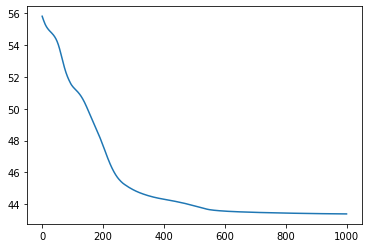

In [58]:
plt.plot(history.history["reconstruction_loss"])

# Training a VAE

In [63]:

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


latent_dim = 64

encoder_inputs = keras.Input(shape=(num_dimensions,))
# x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
# x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
# x = layers.Flatten()(x)
x = layers.Dense(256, activation="tanh")(encoder_inputs)
x = layers.Dense(128, activation="tanh")(x)
x = layers.Dense(64, activation="tanh")(x)
x = layers.Dense(32, activation="tanh")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

latent_inputs = keras.Input(shape=(latent_dim,))
# x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
# x = layers.Reshape((7, 7, 64))(x)
# x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
# x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
# decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
x = layers.Dense(32, activation="tanh")(latent_inputs)
x = layers.Dense(64, activation="tanh")(x)
x = layers.Dense(128, activation="tanh")(x)
x = layers.Dense(256, activation="tanh")(x)
decoder_outputs = layers.Dense(num_dimensions, activation="tanh")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")



class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
#             reconstruction_loss = tf.reduce_mean(
#                 tf.reduce_sum(
#                     keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
#                 )
#             )
            reconstruction_loss = tf.keras.losses.MeanSquaredError()(data,reconstruction)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
#             kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + 0.1 * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

creditdata = np.concatenate([dataset], axis=0)
creditdata = np.expand_dims(creditdata, -1).astype("float32")

vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())
history = vae.fit(creditdata, epochs=1000, batch_size=1024)

Epoch 1/1000
1/1 [==============================] - 0s 1ms/step - loss: 55.3475 - reconstruction_loss: 55.3376 - kl_loss: 0.0996
Epoch 2/1000
1/1 [==============================] - 0s 756us/step - loss: 52.7268 - reconstruction_loss: 52.7165 - kl_loss: 0.1034
Epoch 3/1000
1/1 [==============================] - 0s 916us/step - loss: 50.7689 - reconstruction_loss: 50.7558 - kl_loss: 0.1314
Epoch 4/1000
1/1 [==============================] - 0s 929us/step - loss: 49.3658 - reconstruction_loss: 49.3495 - kl_loss: 0.1636
Epoch 5/1000
1/1 [==============================] - 0s 959us/step - loss: 48.1300 - reconstruction_loss: 48.1108 - kl_loss: 0.1919
Epoch 6/1000
1/1 [==============================] - 0s 902us/step - loss: 47.1613 - reconstruction_loss: 47.1397 - kl_loss: 0.2154
Epoch 7/1000
1/1 [==============================] - 0s 928us/step - loss: 46.2996 - reconstruction_loss: 46.2761 - kl_loss: 0.2346
Epoch 8/1000
1/1 [==============================] - 0s 922us/step - loss: 45.7786 - r

1/1 [==============================] - 0s 887us/step - loss: 42.8417 - reconstruction_loss: 42.7977 - kl_loss: 0.4392
Epoch 126/1000
1/1 [==============================] - 0s 965us/step - loss: 42.8295 - reconstruction_loss: 42.7856 - kl_loss: 0.4390
Epoch 127/1000
1/1 [==============================] - 0s 944us/step - loss: 42.8281 - reconstruction_loss: 42.7843 - kl_loss: 0.4388
Epoch 128/1000
1/1 [==============================] - 0s 1ms/step - loss: 42.8357 - reconstruction_loss: 42.7918 - kl_loss: 0.4387
Epoch 129/1000
1/1 [==============================] - 0s 953us/step - loss: 42.8338 - reconstruction_loss: 42.7899 - kl_loss: 0.4384
Epoch 130/1000
1/1 [==============================] - 0s 937us/step - loss: 42.8403 - reconstruction_loss: 42.7965 - kl_loss: 0.4382
Epoch 131/1000
1/1 [==============================] - 0s 941us/step - loss: 42.8468 - reconstruction_loss: 42.8030 - kl_loss: 0.4381
Epoch 132/1000
1/1 [==============================] - 0s 948us/step - loss: 42.8307 - 

1/1 [==============================] - 0s 1ms/step - loss: 42.8259 - reconstruction_loss: 42.7840 - kl_loss: 0.4190
Epoch 188/1000
1/1 [==============================] - 0s 818us/step - loss: 42.8261 - reconstruction_loss: 42.7842 - kl_loss: 0.4187
Epoch 189/1000
1/1 [==============================] - 0s 891us/step - loss: 42.8326 - reconstruction_loss: 42.7908 - kl_loss: 0.4184
Epoch 190/1000
1/1 [==============================] - 0s 945us/step - loss: 42.8307 - reconstruction_loss: 42.7889 - kl_loss: 0.4182
Epoch 191/1000
1/1 [==============================] - 0s 1ms/step - loss: 42.8254 - reconstruction_loss: 42.7836 - kl_loss: 0.4180
Epoch 192/1000
1/1 [==============================] - 0s 950us/step - loss: 42.8251 - reconstruction_loss: 42.7834 - kl_loss: 0.4178
Epoch 193/1000
1/1 [==============================] - 0s 914us/step - loss: 42.8294 - reconstruction_loss: 42.7876 - kl_loss: 0.4175
Epoch 194/1000
1/1 [==============================] - 0s 1ms/step - loss: 42.8254 - reco

1/1 [==============================] - 0s 934us/step - loss: 42.8204 - reconstruction_loss: 42.7821 - kl_loss: 0.3828
Epoch 312/1000
1/1 [==============================] - 0s 989us/step - loss: 42.8213 - reconstruction_loss: 42.7831 - kl_loss: 0.3825
Epoch 313/1000
1/1 [==============================] - 0s 809us/step - loss: 42.8213 - reconstruction_loss: 42.7831 - kl_loss: 0.3823
Epoch 314/1000
1/1 [==============================] - 0s 1ms/step - loss: 42.8234 - reconstruction_loss: 42.7852 - kl_loss: 0.3820
Epoch 315/1000
1/1 [==============================] - 0s 897us/step - loss: 42.8221 - reconstruction_loss: 42.7840 - kl_loss: 0.3817
Epoch 316/1000
1/1 [==============================] - 0s 1ms/step - loss: 42.8243 - reconstruction_loss: 42.7862 - kl_loss: 0.3815
Epoch 317/1000
1/1 [==============================] - 0s 870us/step - loss: 42.8185 - reconstruction_loss: 42.7804 - kl_loss: 0.3813
Epoch 318/1000
1/1 [==============================] - 0s 954us/step - loss: 42.8319 - re

1/1 [==============================] - 0s 1ms/step - loss: 42.8181 - reconstruction_loss: 42.7833 - kl_loss: 0.3478
Epoch 435/1000
1/1 [==============================] - 0s 1ms/step - loss: 42.8157 - reconstruction_loss: 42.7810 - kl_loss: 0.3472
Epoch 436/1000
1/1 [==============================] - 0s 928us/step - loss: 42.8186 - reconstruction_loss: 42.7840 - kl_loss: 0.3466
Epoch 437/1000
1/1 [==============================] - 0s 958us/step - loss: 42.8172 - reconstruction_loss: 42.7826 - kl_loss: 0.3459
Epoch 438/1000
1/1 [==============================] - 0s 910us/step - loss: 42.8203 - reconstruction_loss: 42.7858 - kl_loss: 0.3454
Epoch 439/1000
1/1 [==============================] - 0s 755us/step - loss: 42.8181 - reconstruction_loss: 42.7836 - kl_loss: 0.3450
Epoch 440/1000
1/1 [==============================] - 0s 987us/step - loss: 42.8146 - reconstruction_loss: 42.7801 - kl_loss: 0.3448
Epoch 441/1000
1/1 [==============================] - 0s 947us/step - loss: 42.8159 - re

1/1 [==============================] - 0s 992us/step - loss: 42.8194 - reconstruction_loss: 42.7854 - kl_loss: 0.3394
Epoch 497/1000
1/1 [==============================] - 0s 1ms/step - loss: 42.8277 - reconstruction_loss: 42.7938 - kl_loss: 0.3390
Epoch 498/1000
1/1 [==============================] - 0s 1ms/step - loss: 42.8223 - reconstruction_loss: 42.7884 - kl_loss: 0.3390
Epoch 499/1000
1/1 [==============================] - 0s 1ms/step - loss: 42.8157 - reconstruction_loss: 42.7818 - kl_loss: 0.3391
Epoch 500/1000
1/1 [==============================] - 0s 940us/step - loss: 42.8130 - reconstruction_loss: 42.7790 - kl_loss: 0.3392
Epoch 501/1000
1/1 [==============================] - 0s 1ms/step - loss: 42.8149 - reconstruction_loss: 42.7809 - kl_loss: 0.3391
Epoch 502/1000
1/1 [==============================] - 0s 1ms/step - loss: 42.8156 - reconstruction_loss: 42.7817 - kl_loss: 0.3389
Epoch 503/1000
1/1 [==============================] - 0s 1ms/step - loss: 42.8157 - reconstruc

1/1 [==============================] - 0s 1ms/step - loss: 42.8135 - reconstruction_loss: 42.7811 - kl_loss: 0.3240
Epoch 621/1000
1/1 [==============================] - 0s 983us/step - loss: 42.8205 - reconstruction_loss: 42.7881 - kl_loss: 0.3236
Epoch 622/1000
1/1 [==============================] - 0s 928us/step - loss: 42.8139 - reconstruction_loss: 42.7815 - kl_loss: 0.3235
Epoch 623/1000
1/1 [==============================] - 0s 910us/step - loss: 42.8152 - reconstruction_loss: 42.7828 - kl_loss: 0.3233
Epoch 624/1000
1/1 [==============================] - 0s 927us/step - loss: 42.8145 - reconstruction_loss: 42.7822 - kl_loss: 0.3231
Epoch 625/1000
1/1 [==============================] - 0s 1ms/step - loss: 42.8145 - reconstruction_loss: 42.7822 - kl_loss: 0.3228
Epoch 626/1000
1/1 [==============================] - 0s 1ms/step - loss: 42.8151 - reconstruction_loss: 42.7829 - kl_loss: 0.3224
Epoch 627/1000
1/1 [==============================] - 0s 1ms/step - loss: 42.8239 - recons

1/1 [==============================] - 0s 1ms/step - loss: 42.8106 - reconstruction_loss: 42.7784 - kl_loss: 0.3216
Epoch 683/1000
1/1 [==============================] - 0s 984us/step - loss: 42.8128 - reconstruction_loss: 42.7806 - kl_loss: 0.3212
Epoch 684/1000
1/1 [==============================] - 0s 2ms/step - loss: 42.8169 - reconstruction_loss: 42.7849 - kl_loss: 0.3207
Epoch 685/1000
1/1 [==============================] - 0s 1ms/step - loss: 42.8244 - reconstruction_loss: 42.7924 - kl_loss: 0.3201
Epoch 686/1000
1/1 [==============================] - 0s 1ms/step - loss: 42.8120 - reconstruction_loss: 42.7801 - kl_loss: 0.3196
Epoch 687/1000
1/1 [==============================] - 0s 1ms/step - loss: 42.8150 - reconstruction_loss: 42.7831 - kl_loss: 0.3189
Epoch 688/1000
1/1 [==============================] - 0s 1ms/step - loss: 42.8122 - reconstruction_loss: 42.7804 - kl_loss: 0.3181
Epoch 689/1000
1/1 [==============================] - 0s 959us/step - loss: 42.8148 - reconstruc

1/1 [==============================] - 0s 1ms/step - loss: 42.8225 - reconstruction_loss: 42.7915 - kl_loss: 0.3098
Epoch 807/1000
1/1 [==============================] - 0s 962us/step - loss: 42.8114 - reconstruction_loss: 42.7805 - kl_loss: 0.3098
Epoch 808/1000
1/1 [==============================] - 0s 980us/step - loss: 42.8117 - reconstruction_loss: 42.7807 - kl_loss: 0.3099
Epoch 809/1000
1/1 [==============================] - 0s 947us/step - loss: 42.8177 - reconstruction_loss: 42.7867 - kl_loss: 0.3099
Epoch 810/1000
1/1 [==============================] - 0s 1ms/step - loss: 42.8152 - reconstruction_loss: 42.7842 - kl_loss: 0.3099
Epoch 811/1000
1/1 [==============================] - 0s 2ms/step - loss: 42.8123 - reconstruction_loss: 42.7813 - kl_loss: 0.3099
Epoch 812/1000
1/1 [==============================] - 0s 1ms/step - loss: 42.8124 - reconstruction_loss: 42.7814 - kl_loss: 0.3098
Epoch 813/1000
1/1 [==============================] - 0s 943us/step - loss: 42.8109 - recons

1/1 [==============================] - 0s 834us/step - loss: 42.8145 - reconstruction_loss: 42.7836 - kl_loss: 0.3095
Epoch 869/1000
1/1 [==============================] - 0s 1ms/step - loss: 42.8216 - reconstruction_loss: 42.7906 - kl_loss: 0.3094
Epoch 870/1000
1/1 [==============================] - 0s 1ms/step - loss: 42.8099 - reconstruction_loss: 42.7790 - kl_loss: 0.3093
Epoch 871/1000
1/1 [==============================] - 0s 962us/step - loss: 42.8098 - reconstruction_loss: 42.7789 - kl_loss: 0.3091
Epoch 872/1000
1/1 [==============================] - 0s 988us/step - loss: 42.8114 - reconstruction_loss: 42.7805 - kl_loss: 0.3088
Epoch 873/1000
1/1 [==============================] - 0s 2ms/step - loss: 42.8107 - reconstruction_loss: 42.7799 - kl_loss: 0.3083
Epoch 874/1000
1/1 [==============================] - 0s 928us/step - loss: 42.8119 - reconstruction_loss: 42.7812 - kl_loss: 0.3077
Epoch 875/1000
1/1 [==============================] - 0s 948us/step - loss: 42.8159 - reco

1/1 [==============================] - 0s 942us/step - loss: 42.8119 - reconstruction_loss: 42.7831 - kl_loss: 0.2882
Epoch 993/1000
1/1 [==============================] - 0s 879us/step - loss: 42.8091 - reconstruction_loss: 42.7803 - kl_loss: 0.2880
Epoch 994/1000
1/1 [==============================] - 0s 973us/step - loss: 42.8104 - reconstruction_loss: 42.7816 - kl_loss: 0.2876
Epoch 995/1000
1/1 [==============================] - 0s 960us/step - loss: 42.8110 - reconstruction_loss: 42.7823 - kl_loss: 0.2870
Epoch 996/1000
1/1 [==============================] - 0s 907us/step - loss: 42.8114 - reconstruction_loss: 42.7827 - kl_loss: 0.2865
Epoch 997/1000
1/1 [==============================] - 0s 1ms/step - loss: 42.8068 - reconstruction_loss: 42.7782 - kl_loss: 0.2859
Epoch 998/1000
1/1 [==============================] - 0s 1ms/step - loss: 42.8090 - reconstruction_loss: 42.7804 - kl_loss: 0.2853
Epoch 999/1000
1/1 [==============================] - 0s 1ms/step - loss: 42.8096 - reco

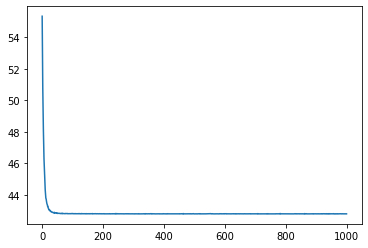

In [64]:
plt.plot(history.history["reconstruction_loss"])

In [67]:
outlier1 = dataset[-1,:].reshape([1,num_dimensions])

z_mean, z_log_var, z = vae.encoder(outlier1)
reconstruction = vae.decoder(z)

reconstruction_loss = tf.keras.losses.MeanSquaredError()(outlier1,reconstruction)
print(outlier1)
print(reconstruction_loss.numpy())

[[ 0.21697507  0.08448299 -0.4086662 ]]
0.579961
